In [2]:
%load_ext autoreload
%autoreload 2
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

from typing import Any

import flax
import jax
import jax.numpy as jnp
import numpy as np
import haiku as hk
import math
import math

from jcm import checkpoints
from jcm import losses
from jcm import sde_lib

# Keep the import below for registering all model definitions
from jcm.models import ddpm, ncsnv2, ncsnpp

from jcm.models import utils as mutils

%matplotlib inline
import matplotlib.pyplot as plt
from jcm import datasets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: XLA_PYTHON_CLIENT_PREALLOCATE=false


## Load model from a checkpoint

In [3]:
## Load CD models
from configs.cifar10_ve_cd import get_config
config = get_config()
rng = hk.PRNGSequence(42)
model, init_model_state, initial_params = mutils.init_model(next(rng), config)
optimizer, optimize_fn = losses.get_optimizer(config)
state = mutils.State(
    step=0,
    lr=4e-4,
    ema_rate=config.model.ema_rate,
    params=initial_params,
    params_ema=initial_params,
    model_state=init_model_state,
    opt_state=optimizer.init(initial_params),
    rng_state=rng.internal_state,
)

## You need to manually download the checkpoint first.
checkpoint_dir = "/path/to/ct/checkpoints"
state = checkpoints.restore_checkpoint(checkpoint_dir, state, step=80)

## Use the following for loading CT models
# from configs.cifar10_ve_ct_adaptive import get_config
# config = get_config()
# rng = hk.PRNGSequence(42)
# model, init_model_state, initial_params = mutils.init_model(next(rng), config)
# optimizer, optimize_fn = losses.get_optimizer(config)
# state = mutils.StateWithTarget(
#     step=0,
#     lr=2e-4,
#     ema_rate=config.model.ema_rate,
#     params=initial_params,
#     target_params=initial_params,
#     params_ema=initial_params,
#     model_state=init_model_state,
#     opt_state=optimizer.init(initial_params),
#     rng_state=rng.internal_state,
# )

# checkpoint_dir = "/path/to/ct/checkpoints"
# state = checkpoints.restore_checkpoint(checkpoint_dir, state, step=74)

sde = sde_lib.get_sde(config)

pstate = flax.jax_utils.replicate(state)

## Various samplers

### Setups

In [4]:
sample_rng = next(rng)
init_z = jax.random.normal(sample_rng, (jax.device_count(), 8, 32, 32, 3))
def plot_grid(samples):
    samples = samples / 2. + 0.5
    samples = samples.transpose((0, 2, 1, 3, 4))
    samples = samples.reshape((samples.shape[0] * samples.shape[1], samples.shape[2] * samples.shape[3], samples.shape[4]))
    plt.figure(figsize=(10,10))
    plt.imshow(samples)
    plt.axis('off')

### One step sampler

In [5]:
def get_onestep_sampler(sde, model, init_std=config.sampling.std):
    def sampler(state, z):        
        x = z
        model_fn = mutils.get_distiller_fn(
            sde,
            model,
            state.params_ema,
            state.model_state,
            train=False,
            return_state=False,
        )
        samples = model_fn(x, jnp.ones((x.shape[0],)) * init_std)
        return samples, 1

    return jax.pmap(sampler, axis_name="batch")

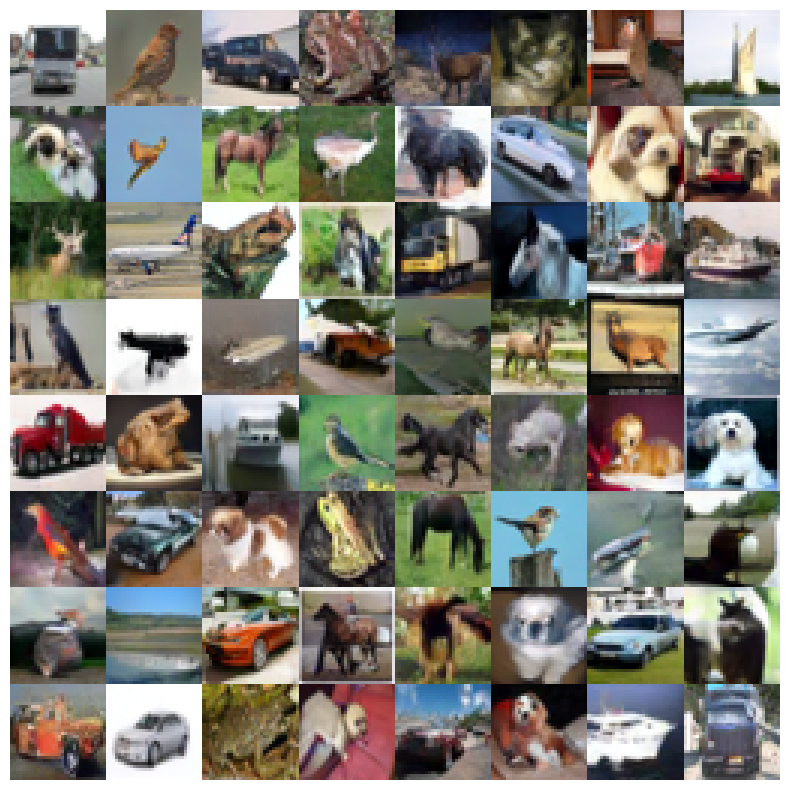

In [6]:
onestep_sampler = get_onestep_sampler(sde, model, init_std=80.)
onestep_samples = onestep_sampler(pstate, init_z * 80.)[0].clip(-1,1)
plot_grid(onestep_samples)

### Spherical linear interpolation

In [7]:
def slerp(z1, z2, t):
    z1 = z1.reshape((-1,))
    z2 = z2.reshape((-1,))
    z1norm = z1 / jnp.linalg.norm(z1, axis=-1, keepdims=True)
    z2norm = z2 / jnp.linalg.norm(z2, axis=-1, keepdims=True)
    dot = jnp.sum(z1norm * z2norm, axis=-1, keepdims=True)
    dot = jnp.clip(dot, -1., 1.)
    theta = jnp.arccos(dot)
    return jnp.sin((1. - t) * theta) / jnp.sin(theta) * z1 + jnp.sin(t * theta) / jnp.sin(theta) * z2

slerp = jax.vmap(slerp, in_axes=(None, None, 0), out_axes=0)

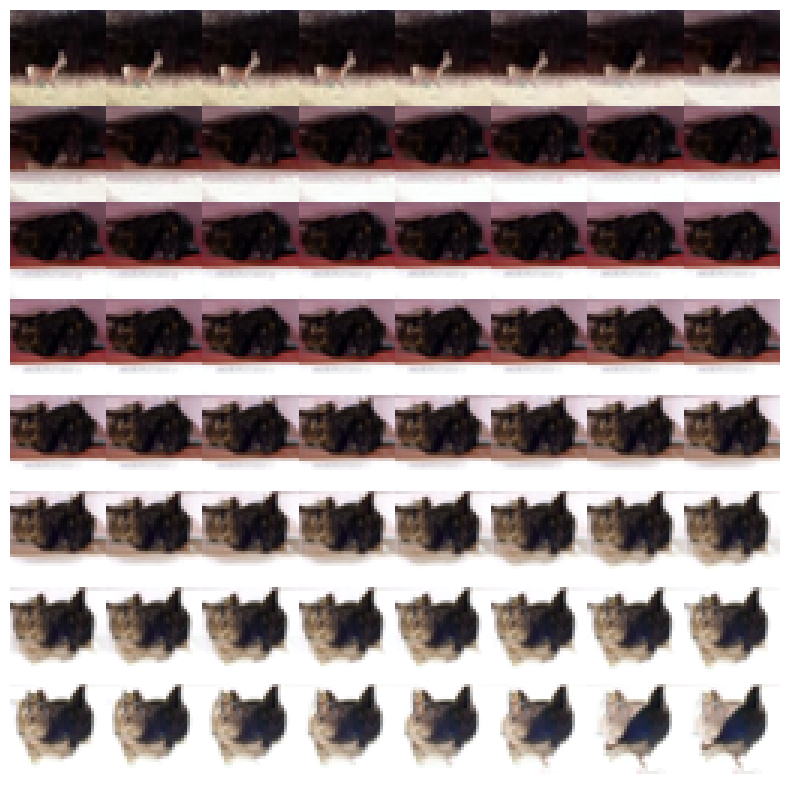

In [8]:
z1 = jax.random.normal(next(rng), (32, 32, 3))
z2 = jax.random.normal(next(rng), (32, 32, 3))
onestep_sampler = get_onestep_sampler(sde, model, init_std=80.)
zs = slerp(z1, z2, jnp.linspace(0., 1., 62))
interp_z = jnp.concatenate([z1[None, ...], zs.reshape((62, 32, 32, 3)), z2[None, ...]], axis=0).reshape(init_z.shape)
interp_samples, _ = onestep_sampler(pstate, interp_z * 80)
plot_grid(interp_samples)

### Denoising

Files already downloaded and verified
Files already downloaded and verified


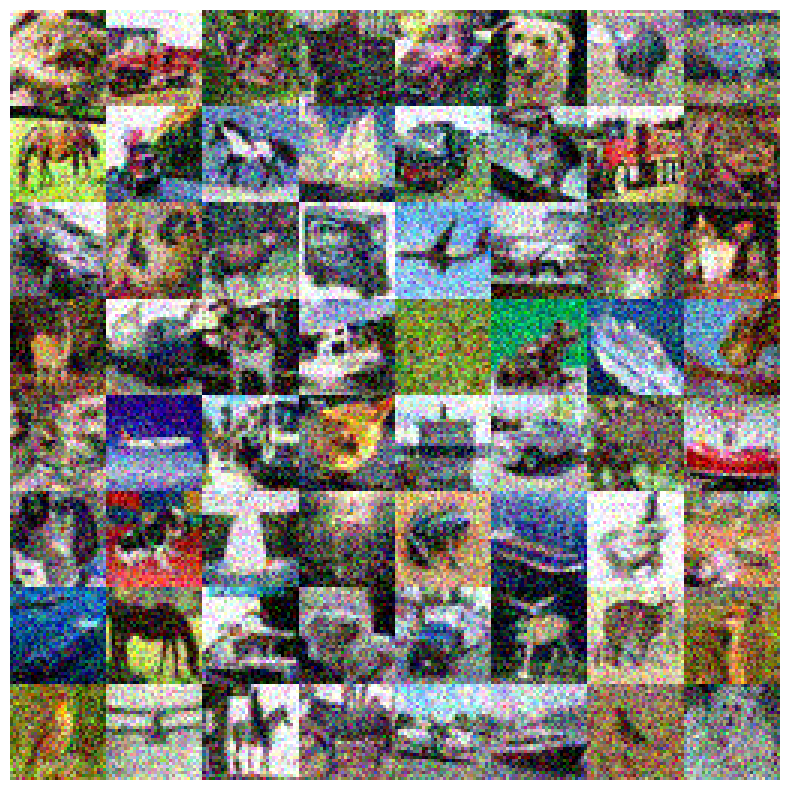

In [11]:
train_ds, eval_ds = datasets.get_dataset(config)
train_iter = iter(train_ds)
eval_iter = iter(eval_ds)

data = jnp.asarray(next(train_iter)['image'])[0].reshape(init_z.shape)
noise_std = sde.t_min**(1/sde.rho) + 5 / (sde.N - 1) * (sde.t_max**(1/sde.rho) - sde.t_min**(1/sde.rho))
noise_std = noise_std ** sde.rho

plot_grid(jnp.clip(data + noise_std * init_z, -1., 1.))

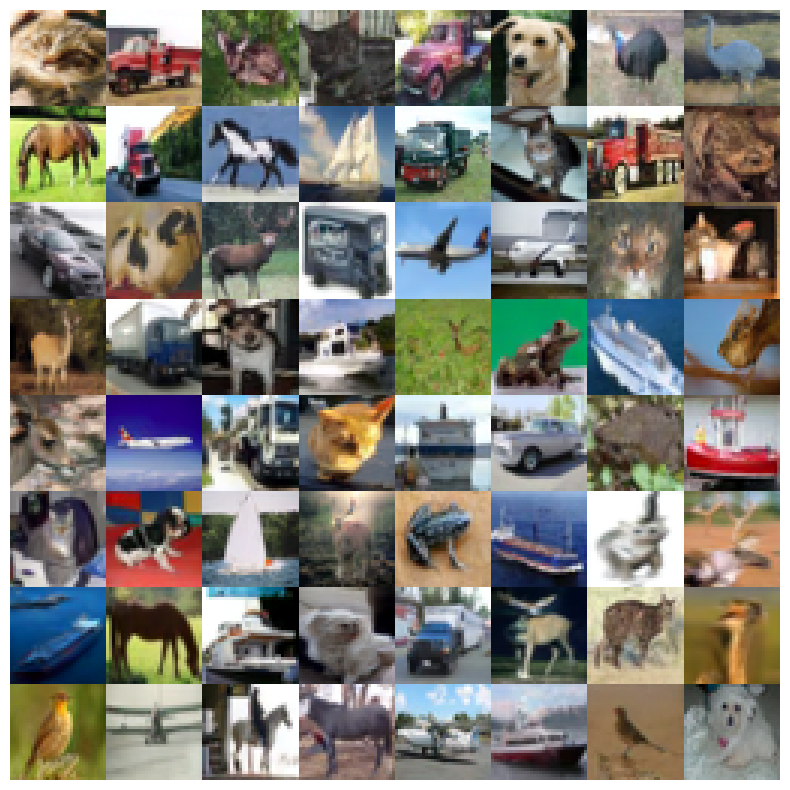

In [12]:
onestep_sampler = get_onestep_sampler(sde, model, init_std=noise_std)
onestep_samples = onestep_sampler(pstate, data + noise_std * init_z)[0].clip(-1., 1.)
plot_grid(onestep_samples)

### Stochastic iterative sampler

In [13]:
def get_stochastic_iterative_sampler(sde, model, train_N=sde.N):
    
    t_max_rho = sde.t_max ** (1/sde.rho)
    t_min_rho = sde.t_min ** (1/sde.rho)

    def sampler(rng, state, init_z, ts):        
        rng = hk.PRNGSequence(rng)
        x = init_z
        
        model_fn = mutils.get_distiller_fn(
            sde,
            model,
            state.params_ema,
            state.model_state,
            train=False,
            return_state=False,
        )
        
        def loop_body(i, val):
            rng, x = val
            t = (t_max_rho + ts[i] / (train_N - 1) * (t_min_rho - t_max_rho)) ** sde.rho
            vec_t = jnp.ones((x.shape[0],)) * t
            x0 = model_fn(x, vec_t)
            x0 = jnp.clip(x0, -1., 1.)
            rng, step_rng = jax.random.split(rng)
            next_t = (t_max_rho + ts[i+1] / (train_N - 1) * (t_min_rho - t_max_rho)) ** sde.rho
            next_t = jnp.clip(next_t, sde.t_min, sde.t_max)
            new_x = x0 + jax.random.normal(step_rng, x0.shape) * jnp.sqrt(next_t**2 - sde.t_min**2)
            return rng, new_x
        
        samples = jax.lax.fori_loop(0, len(ts) - 1, loop_body, (next(rng), x))[1]
        return samples, len(ts) - 1

    return jax.pmap(sampler, axis_name="batch")

In [14]:
iterative_sampler = get_stochastic_iterative_sampler(sde, model, train_N=18)
sample_rng = jnp.asarray(rng.take(8))

In [15]:
ts = flax.jax_utils.replicate(jnp.asarray([0, 11, 17]))
iterative_samples = iterative_sampler(sample_rng, pstate, init_z * 80., ts)
iterative_samples = iterative_samples[0].clip(-1., 1.)

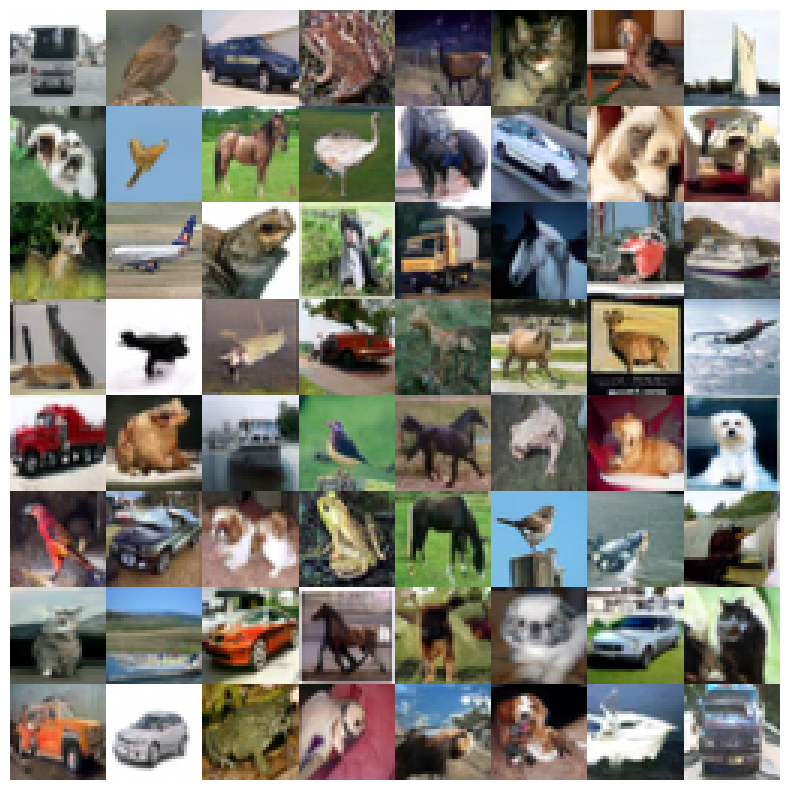

In [16]:
grid = plot_grid(iterative_samples)

### Iterative inpainting

In [17]:
def get_iterative_inpainter(sde, model, train_N=sde.N):
    
    t_max_rho = sde.t_max ** (1/sde.rho)
    t_min_rho = sde.t_min ** (1/sde.rho)
    mask = np.ones((32, 32, 3))
    mask[8:24, 8:24, ...] = 0.
    mask = jnp.asarray(mask)

    def sampler(rng, state, imgs, ts):        
        rng = hk.PRNGSequence(rng)
        
        model_fn = mutils.get_distiller_fn(
            sde,
            model,
            state.params_ema,
            state.model_state,
            train=False,
            return_state=False,
        )

        imgs = imgs * mask + (1. - mask) * jnp.zeros_like(imgs)
        x = imgs + jax.random.normal(next(rng), imgs.shape) * ts[0]
        
        def loop_body(i, val):
            rng, x = val
            t = (t_max_rho + ts[i] / (train_N - 1) * (t_min_rho - t_max_rho)) ** sde.rho
            vec_t = jnp.ones((x.shape[0],)) * t
            x0 = model_fn(x, vec_t)
            x0 = jnp.clip(x0, -1., 1.)
            x0 = imgs * mask + (1. - mask) * x0
            rng, step_rng = jax.random.split(rng)
            next_t = (t_max_rho + ts[i+1] / (train_N - 1) * (t_min_rho - t_max_rho)) ** sde.rho
            next_t = jnp.clip(next_t, sde.t_min, sde.t_max)
            new_x = x0 + jax.random.normal(step_rng, x0.shape) * jnp.sqrt(next_t**2 - sde.t_min**2)
            return rng, new_x
        
        samples = jax.lax.fori_loop(0, len(ts) - 1, loop_body, (next(rng), x))[1]
        return samples, imgs, len(ts) - 1

    return jax.pmap(sampler, axis_name="batch")

In [18]:
iterative_inpainter = get_iterative_inpainter(sde, model, train_N=18)

Files already downloaded and verified
Files already downloaded and verified


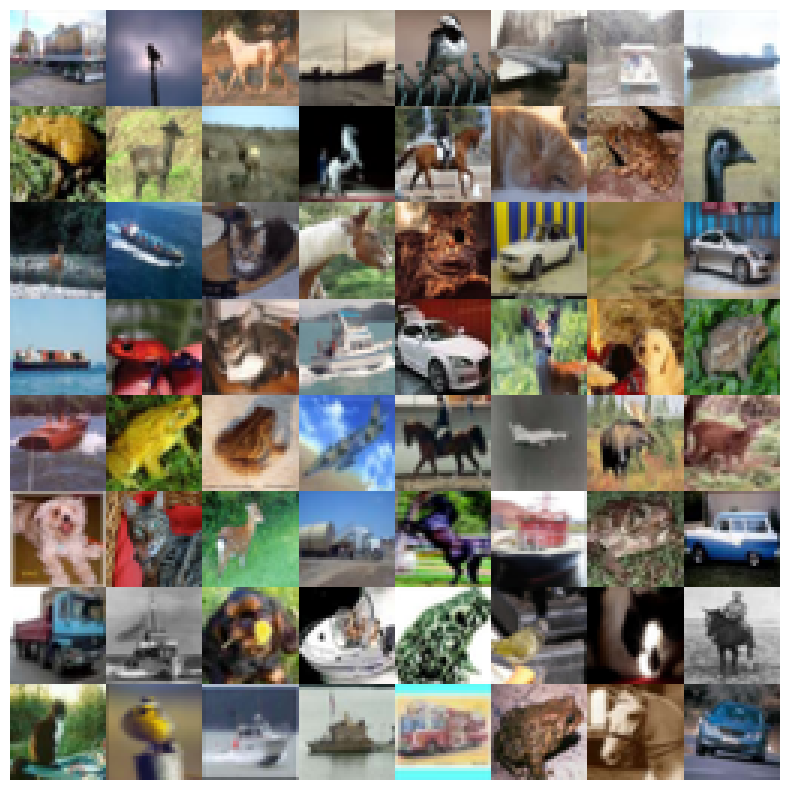

In [19]:
train_ds, eval_ds = datasets.get_dataset(config)
train_iter = iter(train_ds)
eval_iter = iter(eval_ds)
data = jnp.asarray(next(train_iter)['image'])[0].reshape(init_z.shape)
plot_grid(data)

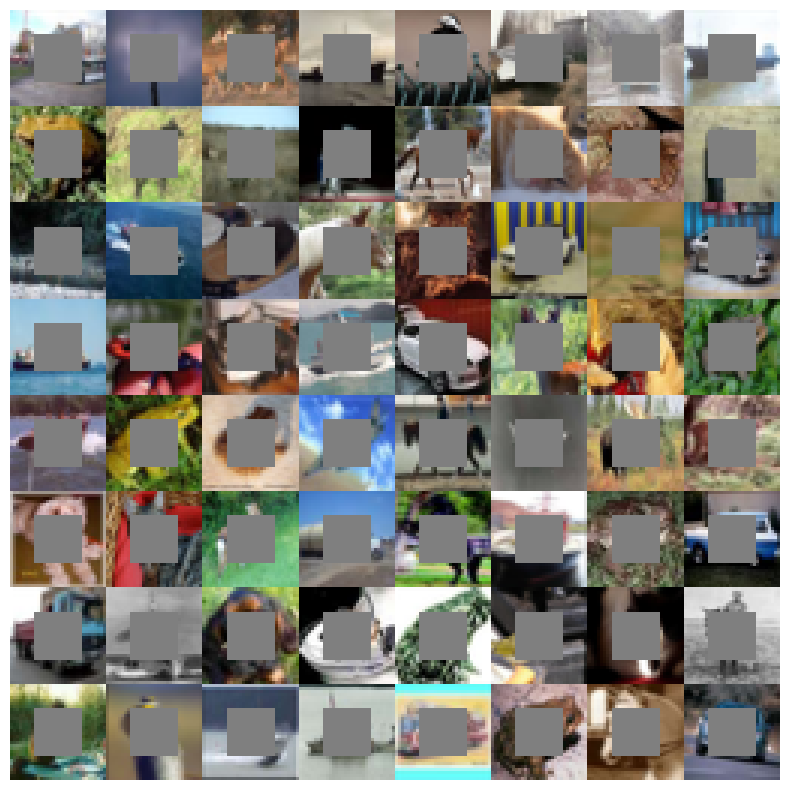

In [20]:
ts = flax.jax_utils.replicate(jnp.arange(18))
iterative_samples = iterative_inpainter(sample_rng, pstate, data, ts)
plot_grid(iterative_samples[1])

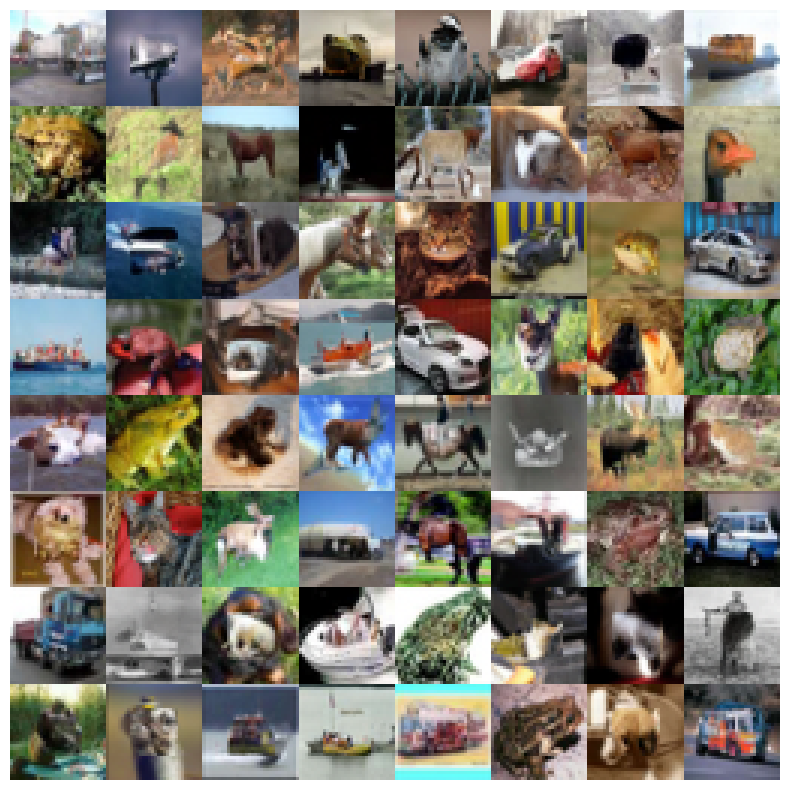

In [21]:
plot_grid(iterative_samples[0])

### Get iterative colorizer

In [22]:
def get_iterative_colorizer(sde, model, train_N=sde.N):
    
    t_max_rho = sde.t_max ** (1/sde.rho)
    t_min_rho = sde.t_min ** (1/sde.rho)    

    def rbg2gray(imgs):
        return imgs[..., 0] * 0.2989 + imgs[..., 1] * 0.5870 + imgs[..., 2] * 0.1140

    def obtain_orthogonal_matrix():
        vector = np.asarray([0.2989, 0.5870, 0.1140])
        vector = vector / np.linalg.norm(vector)        
        matrix = np.eye(3)
        matrix[:, 0] = vector
        matrix = np.linalg.qr(matrix)[0]
        if np.sum(matrix[:, 0]) < 0:
            matrix = - matrix
        return matrix
    
    Q = obtain_orthogonal_matrix()
    mask = np.zeros((32, 32, 3))
    mask[..., 0] = 1.0

    def replacement(x0, x1):        
        x0 = jnp.einsum('bhwc,cd->bhwd', x0, Q)
        x1 = jnp.einsum('bhwc,cd->bhwd', x1, Q)

        x_mix = x0 * mask + x1 * (1. - mask)
        x_mix = jnp.einsum('bhwd,cd->bhwc', x_mix, Q)        
        return x_mix

    def sampler(rng, state, imgs, ts):        
        rng = hk.PRNGSequence(rng)
        
        model_fn = mutils.get_distiller_fn(
            sde,
            model,
            state.params_ema,
            state.model_state,
            train=False,
            return_state=False,
        )

        imgs = replacement(imgs, jnp.zeros_like(imgs))
        x = imgs + jax.random.normal(next(rng), imgs.shape) * ts[0]        
        
        def loop_body(i, val):
            rng, x = val
            t = (t_max_rho + ts[i] / (train_N - 1) * (t_min_rho - t_max_rho)) ** sde.rho
            vec_t = jnp.ones((x.shape[0],)) * t
            x0 = model_fn(x, vec_t)
            x0 = jnp.clip(x0, -1., 1.)            
            x0 = replacement(imgs, x0)
            rng, step_rng = jax.random.split(rng)
            next_t = (t_max_rho + ts[i+1] / (train_N - 1) * (t_min_rho - t_max_rho)) ** sde.rho
            next_t = jnp.clip(next_t, sde.t_min, sde.t_max)
            new_x = x0 + jax.random.normal(step_rng, x0.shape) * jnp.sqrt(next_t**2 - sde.t_min**2)
            return rng, new_x
        
        samples = jax.lax.fori_loop(0, len(ts) - 1, loop_body, (next(rng), x))[1]
        return samples, imgs, len(ts) - 1

    return jax.pmap(sampler, axis_name="batch")

Files already downloaded and verified
Files already downloaded and verified


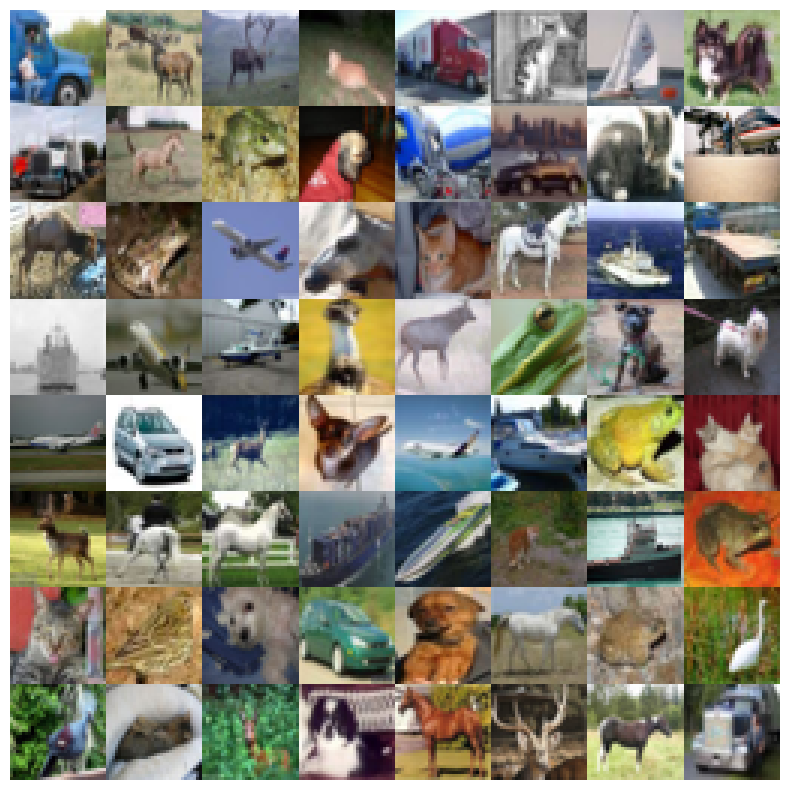

In [23]:
iterative_colorizer = get_iterative_colorizer(sde, model, train_N=18)
train_ds, eval_ds = datasets.get_dataset(config)
train_iter = iter(train_ds)
eval_iter = iter(eval_ds)
data = jnp.asarray(next(train_iter)['image'])[0].reshape(init_z.shape)
plot_grid(data)

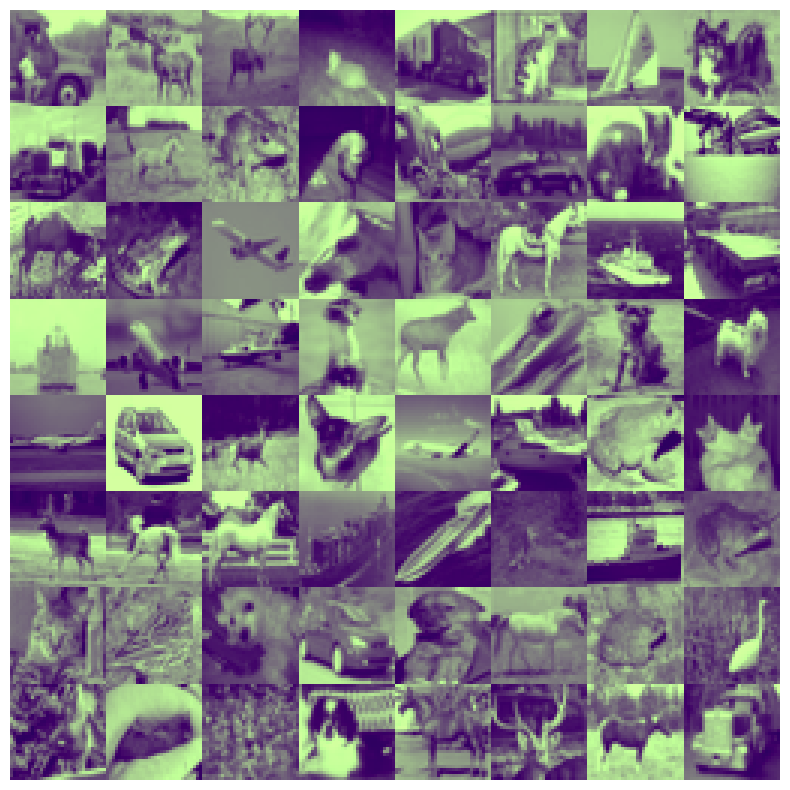

In [28]:
ts = flax.jax_utils.replicate(jnp.arange(18))
iterative_samples = iterative_colorizer(sample_rng, pstate, data, ts)
plot_grid(iterative_samples[1])

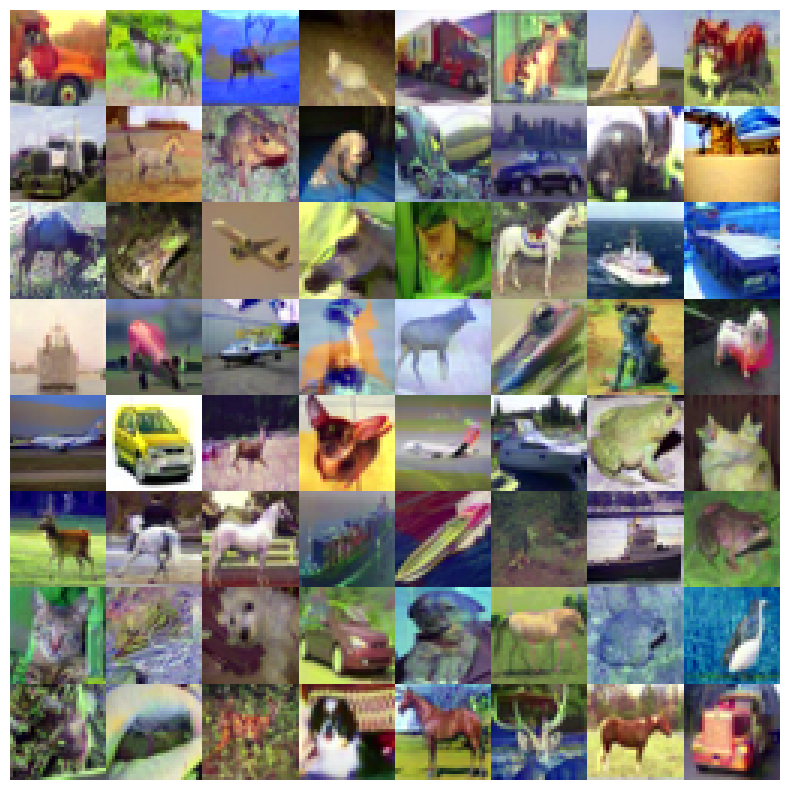

In [29]:
plot_grid(iterative_samples[0])

### Iterative super-resolution

In [30]:
import numpy as np

def get_iterative_superres(sde, model, train_N=sde.N, patch_size=4):    
    t_max_rho = sde.t_max ** (1/sde.rho)
    t_min_rho = sde.t_min ** (1/sde.rho)   
    
    def obtain_orthogonal_matrix():
        vector = np.asarray([1] * patch_size**2)
        vector = vector / np.linalg.norm(vector)        
        matrix = np.eye(patch_size**2)
        matrix[:, 0] = vector
        matrix = np.linalg.qr(matrix)[0]
        if np.sum(matrix[:, 0]) < 0:
            matrix = - matrix
        return matrix
    
    Q = obtain_orthogonal_matrix()

    def replacement(x0, x1):        
        x0_flatten = x0.reshape(-1, 32, 32, 3).reshape(-1, 32//patch_size, patch_size, 32//patch_size, patch_size, 3).transpose(0, 1, 3, 2, 4, 5).reshape(-1, 32**2//patch_size**2, patch_size**2, 3)
        x1_flatten = x1.reshape(-1, 32, 32, 3).reshape(-1, 32//patch_size, patch_size, 32//patch_size, patch_size, 3).transpose(0, 1, 3, 2, 4, 5).reshape(-1, 32**2//patch_size**2, patch_size**2, 3)
        x0 = jnp.einsum('bndc,de->bnec', x0_flatten, Q)
        x1 = jnp.einsum('bndc,de->bnec', x1_flatten, Q)
        x_mix = jnp.zeros_like(x0)
        x_mix = x_mix.at[..., 0, :].set(x0[..., 0, :])
        x_mix = x_mix.at[..., 1:, :].set(x1[..., 1:, :])
        x_mix = jnp.einsum('bnec,de->bndc', x_mix, Q)                
        x_mix = x_mix.reshape(-1, 32//patch_size, 32//patch_size, patch_size, patch_size, 3).transpose(0, 1, 3, 2, 4, 5).reshape(-1, 32, 32, 3)
        return x_mix
    
    def sampler(rng, state, imgs, ts):        
        rng = hk.PRNGSequence(rng)
        
        model_fn = mutils.get_distiller_fn(
            sde,
            model,
            state.params_ema,
            state.model_state,
            train=False,
            return_state=False,
        )

        imgs = replacement(imgs, jnp.zeros_like(imgs))
        x = imgs + jax.random.normal(next(rng), imgs.shape) * ts[0]        
        
        def loop_body(i, val):
            rng, x = val
            t = (t_max_rho + ts[i] / (train_N - 1) * (t_min_rho - t_max_rho)) ** sde.rho
            vec_t = jnp.ones((x.shape[0],)) * t
            x0 = model_fn(x, vec_t)
            x0 = jnp.clip(x0, -1., 1.)            
            x0 = replacement(imgs, x0)
            rng, step_rng = jax.random.split(rng)
            next_t = (t_max_rho + ts[i+1] / (train_N - 1) * (t_min_rho - t_max_rho)) ** sde.rho
            next_t = jnp.clip(next_t, sde.t_min, sde.t_max)
            new_x = x0 + jax.random.normal(step_rng, x0.shape) * jnp.sqrt(next_t**2 - sde.t_min**2)
            return rng, new_x
        
        samples = jax.lax.fori_loop(0, len(ts) - 1, loop_body, (next(rng), x))[1]
        return samples, imgs, len(ts) - 1

    return jax.pmap(sampler, axis_name="batch")

Files already downloaded and verified
Files already downloaded and verified


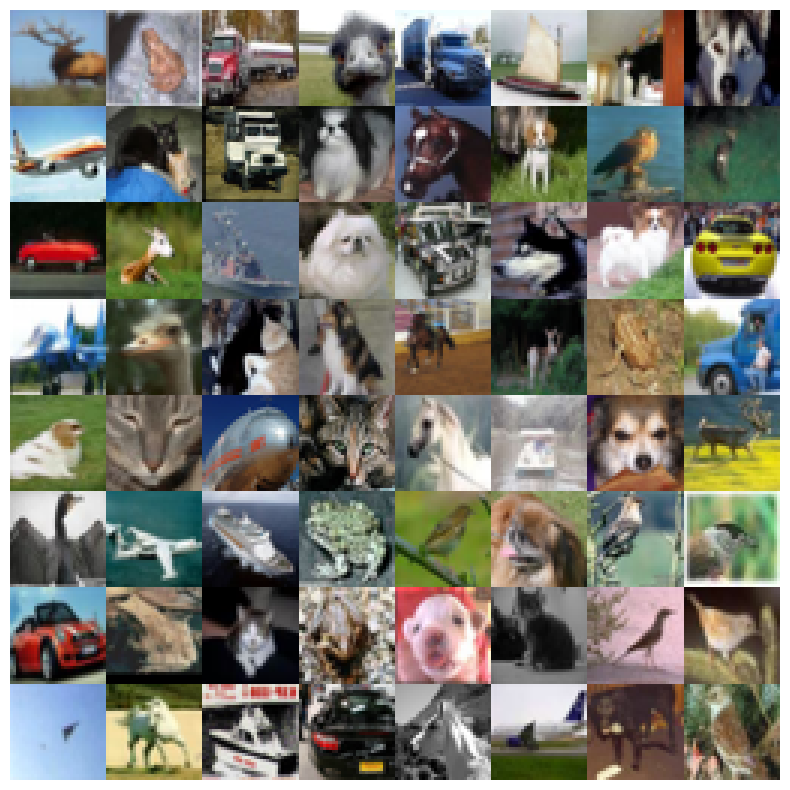

In [31]:
iterative_superres = get_iterative_superres(sde, model, train_N=18, patch_size=2)
train_ds, eval_ds = datasets.get_dataset(config)
train_iter = iter(train_ds)
eval_iter = iter(eval_ds)
data = jnp.asarray(next(train_iter)['image'])[0].reshape(init_z.shape)
plot_grid(data)

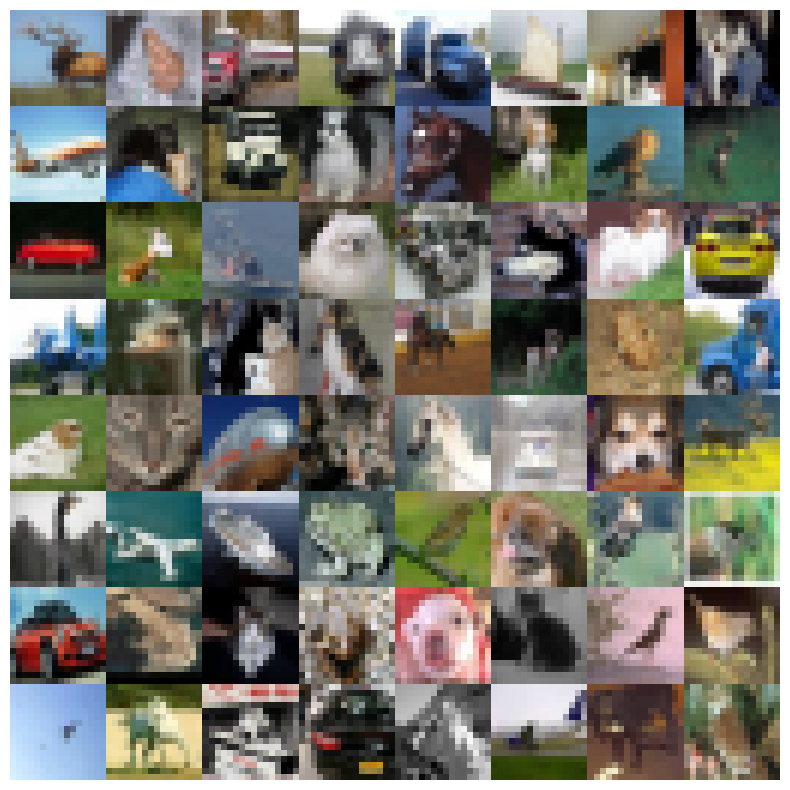

In [32]:
ts = flax.jax_utils.replicate(jnp.arange(18))
iterative_samples = iterative_superres(sample_rng, pstate, data, ts)
plot_grid(iterative_samples[1])

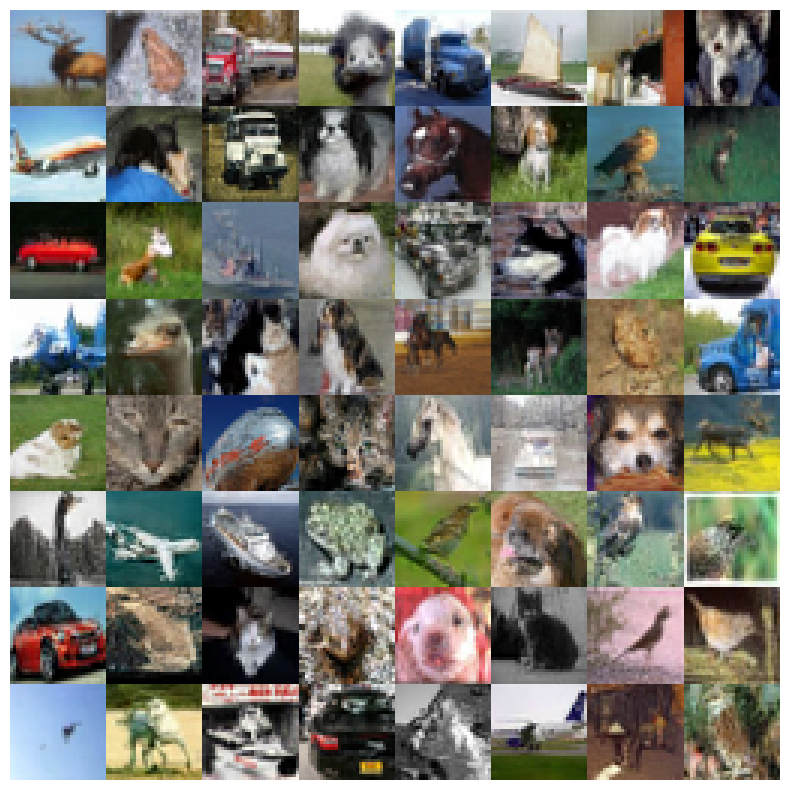

In [33]:
plot_grid(iterative_samples[0])

## FIDs

In [47]:
from jcm.metrics import compute_fid_jupyter
from jcm.metrics import obtain_feature_extractor
feature_extractor = obtain_feature_extractor()

### Ternary search to minimize FIDs

In [48]:
# Rerun this module to update pstate and samplers

num_samples = 50000
batch_size = 1024
num_batches = int(math.ceil(num_samples / batch_size))
batch_size_per_device = batch_size // jax.local_device_count()

stochastic_sampler = get_stochastic_iterative_sampler(sde, model, train_N=18)

import functools

@functools.cache
def get_fid(p, before=(0,), after=(17,)):
    rng = hk.PRNGSequence(4)
    for batch in range(num_batches):
        z_rng = next(rng)
        batch_z = jax.random.normal(z_rng, (jax.local_device_count(), batch_size_per_device, 32, 32, 3))
        batch_rng = jnp.asarray(rng.take(jax.local_device_count()))
        ts = flax.jax_utils.replicate(jnp.asarray(before + (p,) + after))
        samples, _ = stochastic_sampler(batch_rng, pstate, batch_z * 80., ts)
        samples = samples.reshape((-1, 32, 32, 3))
        if batch == 0:
            all_samples = samples
        else:
            all_samples = jnp.concatenate([all_samples, samples], axis=0)

    all_samples = np.asarray(((jnp.clip(all_samples, -1., 1.) + 1.)* 127.5).astype(jnp.uint8)[:num_samples])
    fid = compute_fid_jupyter(all_samples, feature_extractor)
    return fid

# ternary search to find the smallest fid
def ternary_search(before=(0,), after=(17,)):
    l = before[-1]
    r = after[0]
    while r - l >= 3:
        m1 = int(l + (r - l) / 3.)
        m2 = int(r - (r - l) / 3.)
        f1 = get_fid(m1, before, after)
        print(f'fid at m1 = {m1} is {f1}')
        f2 = get_fid(m2, before, after)
        print(f'fid at m2 = {m2} is {f2}')
        if f1 < f2:
            r = m2
        else:
            l = m1
        print(f'new interval is [{l}, {r}]')
    
    if r == l:
        p = r
    elif r - l == 1:
        p = m1 if f1 < f2 else m2
    elif r - l == 2:
        mid = l + 1
        fmid = get_fid(mid, before, after)
        print(f'fmid at mid = {mid} is {fmid}')
        if fmid < f1 and fmid < f2:
            p = mid
        elif f1 < f2:
            p = m1
        else:
            p = m2
    
    print(f"optimal p is {p}, with fid = {get_fid(p, before, after)}")
    return p

In [ ]:
ternary_search(before=(0,), after=(17,))

100%|█████████████████████████████████████████████████| 49/49 [00:52<00:00,  1.07s/it]


downloading statistics to /root/.pyenv/versions/3.9.9/lib/python3.9/site-packages/cleanfid/stats/cifar10_legacy_tensorflow_train_32.npz
fid at m1 = 5 is 3.6492091960133166


100%|█████████████████████████████████████████████████| 49/49 [00:16<00:00,  3.04it/s]


fid at m2 = 11 is 2.927998426302622
new interval is [5, 17]


100%|█████████████████████████████████████████████████| 49/49 [00:15<00:00,  3.11it/s]


fid at m1 = 9 is 3.3185499075211737


  2%|█                                                 | 1/49 [00:03<02:34,  3.22s/it]

100%|█████████████████████████████████████████████████| 49/49 [00:16<00:00,  3.04it/s]


fid at m2 = 13 is 3.2767175246792704
new interval is [9, 17]
fid at m1 = 11 is 2.927998426302622


100%|█████████████████████████████████████████████████| 49/49 [00:15<00:00,  3.07it/s]


fid at m2 = 14 is 3.4600583075581426
new interval is [9, 14]


100%|█████████████████████████████████████████████████| 49/49 [00:16<00:00,  3.01it/s]


fid at m1 = 10 is 3.050687909550618


100%|█████████████████████████████████████████████████| 49/49 [00:15<00:00,  3.12it/s]


fid at m2 = 12 is 3.0490236113702736
new interval is [10, 14]
fid at m1 = 11 is 2.927998426302622
fid at m2 = 12 is 3.0490236113702736
new interval is [10, 12]
fmid at mid = 11 is 2.927998426302622
optimal p is 11, with fid = 2.927998426302622


11